In [1]:
# ===== 📦 Cell 1: Install Required Packages =====
!pip install -q pyspark==3.0.3 h2o h2o_pysparkling_3.0 findspark pandas matplotlib scikit-learn shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.1/209.1 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.4/232.4 MB 4.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.9/265.9 MB 5.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-spark-connect 0.5.3 requires pyspark[connect]>=3.5, but you have pyspark 3.0.3 which is incompatible.


In [2]:
# ===== 🚀 Cell 2: Initialize H2O Standalone =====
import h2o
h2o.init(max_mem_size='8G')

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.26" 2025-01-21; OpenJDK Runtime Environment (build 11.0.26+4-post-Ubuntu-1ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.26+4-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.11/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpeuzmvrud
  JVM stdout: /tmp/tmpeuzmvrud/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpeuzmvrud/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,1 month and 10 days
H2O_cluster_name:,H2O_from_python_unknownUser_yj7l81
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [3]:
# ===== 📂 Cell 3: Load Preprocessed Data =====
import pandas as pd, os, shutil
from google.colab import files
# Upload files if not present
for fname in ['train_preprocessed.csv','test_preprocessed.csv']:
    if not os.path.isfile(f'/content/{fname}'):
        files.upload()
# Read
train_pd = pd.read_csv('/content/train_preprocessed.csv')
test_pd  = pd.read_csv('/content/test_preprocessed.csv')
# Convert to H2OFrame and preprocess
target = 'readmit_30_days'
train_hf = h2o.H2OFrame(train_pd)
test_hf  = h2o.H2OFrame(test_pd)
train_hf[target] = train_hf[target].asfactor()
test_hf[target]  = test_hf[target].asfactor()
# Split
train_split, valid_split = train_hf.split_frame(ratios=[0.85], seed=42)
features = [c for c in train_hf.columns if c.startswith('PC')]
# Create models directory
os.makedirs('/content/models', exist_ok=True)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [4]:
# ===== 🆕 Cell 4: Train & Save DRF (Grid Search) =====
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch
# Grid search
drf_est = H2ORandomForestEstimator(seed=42)
hyper_params = {'ntrees': [50, 100], 'max_depth': [10, 20]}
grid = H2OGridSearch(model=drf_est, hyper_params=hyper_params, search_criteria={'strategy': 'Cartesian'})
grid.train(x=features, y=target, training_frame=train_split)
best_drf = grid.get_grid(sort_by='auc', decreasing=True).models[0]
# Evaluate
perf = best_drf.model_performance(test_data=test_hf)
print(f"DRF Best AUC={perf.auc():.4f}")
# Save
path = h2o.save_model(best_drf, path='/content/models', force=True)
print("Saved DRF to", path)

drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
DRF Best AUC=0.9859
Saved DRF to /content/models/Grid_DRF_py_3_sid_b9cc_model_python_1746680667730_1_model_4


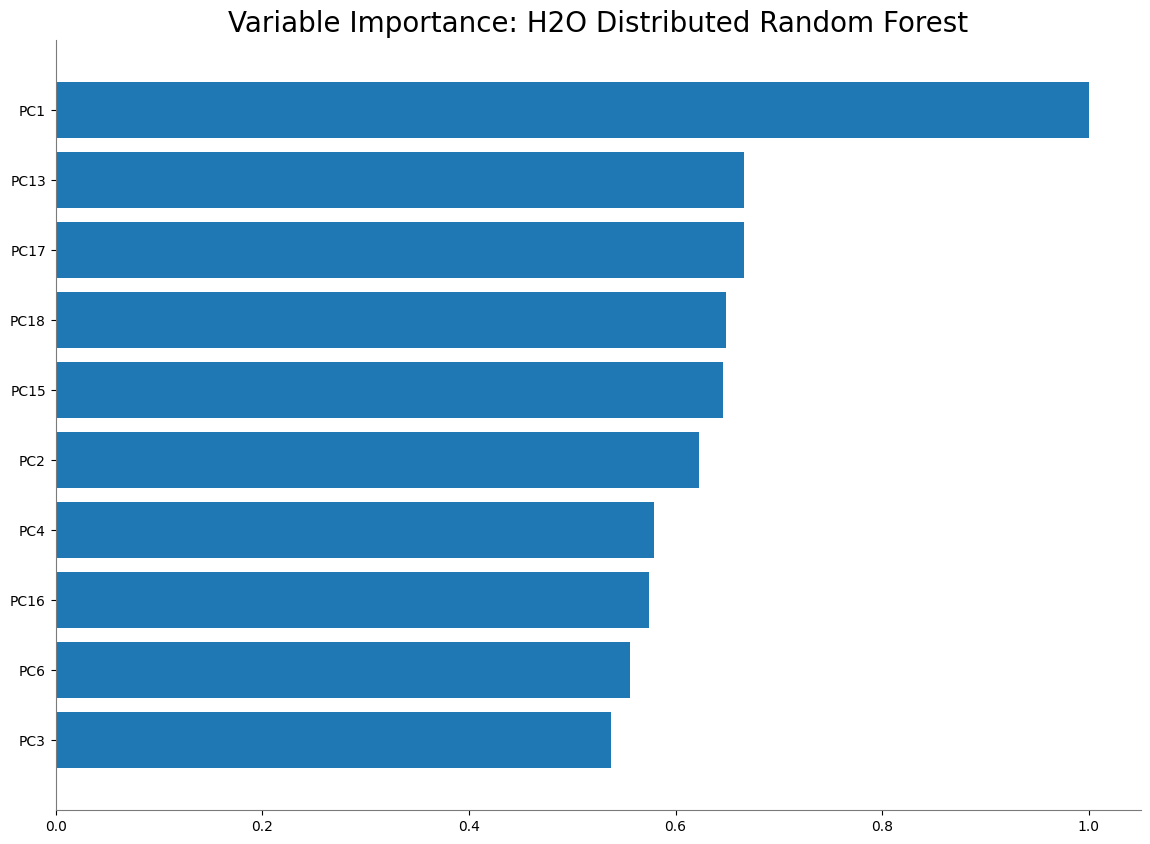

<Figure size 640x480 with 0 Axes>

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Classification Report for DRF:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94     26425
           1       0.94      0.95      0.94     26501

    accuracy                           0.94     52926
   macro avg       0.94      0.94      0.94     52926
weighted avg       0.94      0.94      0.94     52926



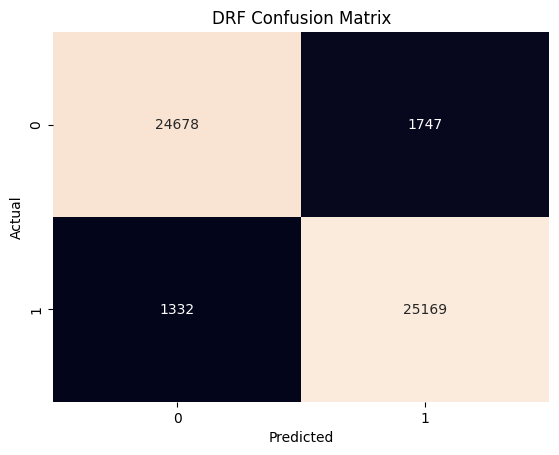

In [7]:
# Plot variable importance
import matplotlib.pyplot as plt
best_drf.varimp_plot()
plt.show()
# Confusion matrix & classification report
from sklearn.metrics import confusion_matrix, classification_report
preds_df = best_drf.predict(test_hf).as_data_frame()
y_true = test_pd[target].astype(int)
y_pred = preds_df['predict'].astype(int)
print("Classification Report for DRF:")
print(classification_report(y_true, y_pred))
import seaborn as sns
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.title('DRF Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [16]:
# ===== 🆕 Cell 5: Train, Save & Plot XGBoost =====
from h2o.estimators.xgboost import H2OXGBoostEstimator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Train XGBoost using train_split and valid_split
xgb = H2OXGBoostEstimator(ntrees=100, max_depth=5, learn_rate=0.1, seed=42)
xgb.train(x=features, y=target, training_frame=train_split, validation_frame=valid_split)


xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_model_python_1746680667730_75


Model Summary: 
    number_of_trees
--  -----------------
    100

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.2197790494673717
RMSE: 0.468805982755523
LogLoss: 0.6300625346020866
Mean Per-Class Error: 0.38052594666381895
AUC: 0.7122974671819688
AUCPR: 0.7005940130954488
Gini: 0.4245949343639377

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.405888365235245
       0      1      Error    Rate
-----  -----  -----  -------  ------------------
0      17563  34721  0.6641   (34721.0/52284.0)
1      5103   47523  0.097    (5103.0/52626.0)
Total  22666  82244  0.3796   (39824.0/104910.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.405888     0.704723  264
max f2                       0.335443     0.843899  317
max f0point5                 0.484623     0.650758  195
max accuracy                 0.484623     0.651215  195
max precision                0.831365     1         0
max recall                   0.125181     1         394
max specificity              0.831365     1         0
max absolute_mcc             0.472147     0.304426  205
max min_per_class_accuracy   0.499739     0.648311  182
max mean_per_class_accuracy  0.484623     0.651085  195
max tns                      0.831365     52284     0
max fns                      0.831365     52621     0
max fps                      0.0923432    52284     399
max tps                      0.125181     52626     394
max tnr                      0.831365     1         0
max fnr                      0.831365     0.999905  0
max fpr                      0.0923432    1         399
max tpr                      0.125181     1         394

Gains/Lift Table: Avg response rate: 50.16 %, avg score: 50.17 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100467                   0.726917           1.88569   1.88569            0.94592          0.743363  0.94592                     0.743363            0.018945        0.018945                   88.5693   88.5693            0.0178548
2        0.0200267                   0.710357           1.74217   1.81417            0.873926         0.717805  0.910043                    0.730627            0.0173868       0.0363319                  74.2172   81.4172            0.032717
3        0.0300067                   0.697196           1.63364   1.75413            0.819484         0.7036    0.879924                    0.721638            0.0163037       0.0526356                  63.3643   75.4129            0.0454058
4        0.0400057                   0.68737            1.62103   1.72086            0.813155         0.692176  0.863236                    0.714274            0.0162087       0.0688443                  62.1026   72.0861            0.0578658
5        0.0500143                   0.679566           1.60809   1.69829            0.806667         0.683221  0.851915                    0.70806             0.0160947       0.084939                   60.8091   69.8294            0.0700779
6        0.1                         0.646893           1.5225    1.61042            0.76373          0.661677  0.807835                    0.684875            0.0761031       0.161042                   52.2497   61.0421            0.122483
7        0.150014                    0.627353           1.41411   1.54497  

In [17]:
# Performance
# Use test_hf instead of hf_test
xgb_perf = xgb.model_performance(test_data=test_hf)
print(f"XGBoost AUC={xgb_perf.auc():.4f}, Accuracy={xgb_perf.accuracy()[0][1]:.4f}")

XGBoost AUC=0.6871, Accuracy=0.6320


In [18]:
# Save model
path_xgb = h2o.save_model(xgb, path='/content/models', force=True)
print("Saved XGBoost to", path_xgb)

Saved XGBoost to /content/models/XGBoost_model_python_1746680667730_75


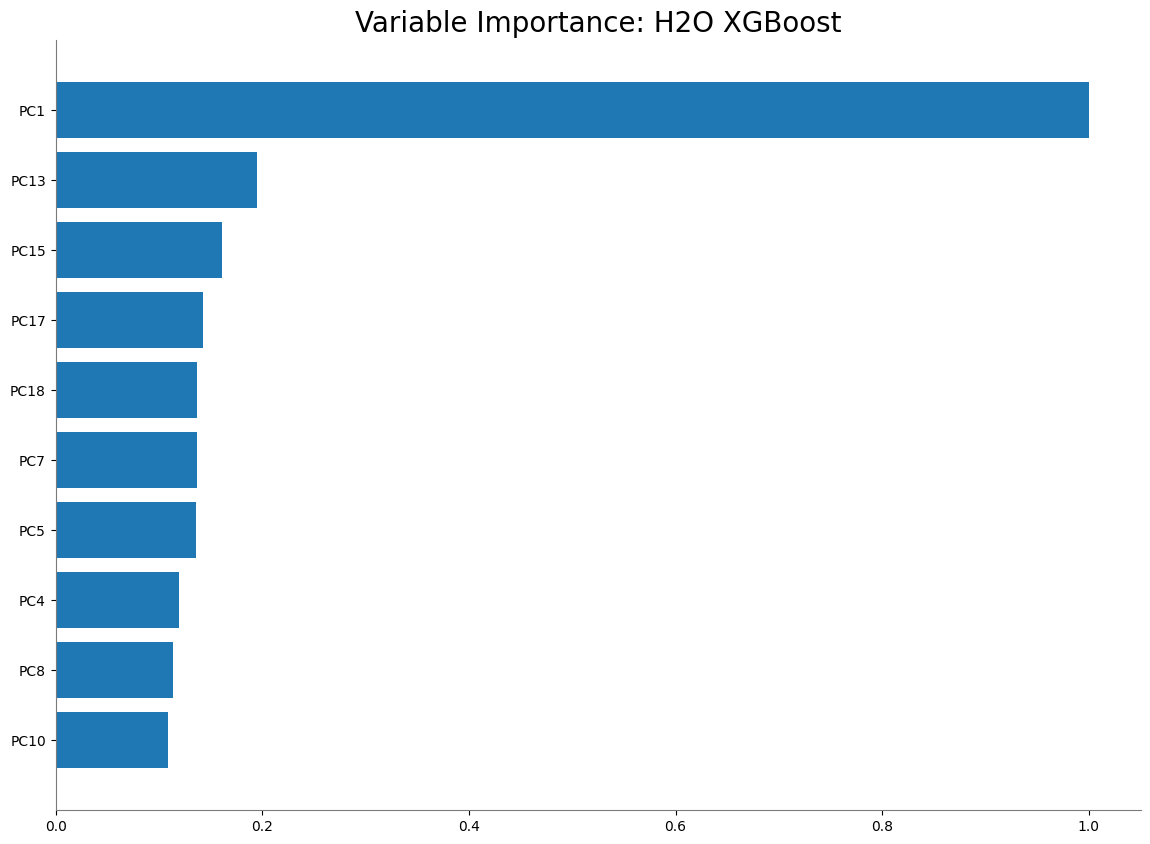

<Figure size 640x480 with 0 Axes>

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


              precision    recall  f1-score   support

           0       0.81      0.21      0.33     26425
           1       0.55      0.95      0.69     26501

    accuracy                           0.58     52926
   macro avg       0.68      0.58      0.51     52926
weighted avg       0.68      0.58      0.51     52926



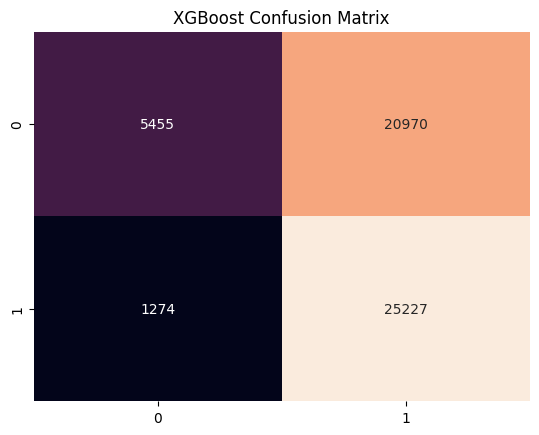

In [20]:
# Variable importance
xgb.varimp_plot()
plt.show()
# Confusion & report
pred = xgb.predict(test_hf).as_data_frame()
y_pred = pred['predict'].astype(int)
print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.title('XGBoost Confusion Matrix')
plt.show()

In [21]:
# ===== 🆕 Cell 6: Train, Save & Plot Deep Learning =====
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
# Train DL
dl = H2ODeepLearningEstimator(hidden=[50,50], epochs=20, activation='Tanh', seed=42)
dl.train(x=features, y=target, training_frame=train_split, validation_frame=valid_split)

deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_model_python_1746680667730_105


Status of Neuron Layers: predicting readmit_30_days, 2-class classification, bernoulli distribution, CrossEntropy loss, 3,602 weights/biases, 50.0 KB, 511,313 training samples, mini-batch size 1
    layer    units    type     dropout    l1    l2    mean_rate             rate_rms               momentum    mean_weight             weight_rms           mean_bias               bias_rms
--  -------  -------  -------  ---------  ----  ----  --------------------  ---------------------  ----------  ----------------------  -------------------  ----------------------  --------------------
    1        18       Input    0.0
    2        50       Tanh     0.0        0.0   0.0   0.01304404952822046   0.002762473188340664   0.0         -0.0033513434874475933  0.1394004225730896   0.007835939734284909    0.09764683246612549
    3        50       Tanh     0.0        0.0   0.0   0.19657639317717404   0.16619449853897095    0.0         0.006435932255431544    0.15056031942367554  0.015400586254209047    0.11223244667053223
    4        2        Softmax             0.0   0.0   0.004760425607673824  0.0015489035286009312  0.0         0.030102543872781096    0.5057833194732666   -0.0006757744844550131  0.021561481058597565

ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.23833733983817798
RMSE: 0.48819805390658616
LogLoss: 0.6695378829808983
Mean Per-Class Error: 0.47582153297619034
AUC: 0.6263841995497693
AUCPR: 0.612037388452593
Gini: 0.25276839909953863

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35363151462051257
       0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      417  4538  0.9158   (4538.0/4955.0)
1      178  4794  0.0358   (178.0/4972.0)
Total  595  9332  0.4751   (4716.0/9927.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.353632     0.670302  362
max f2                       0.289081     0.833976  395
max f0point5                 0.491952     0.596906  231
max accuracy                 0.495966     0.595749  227
max precision                0.764816     0.77193   15
max recall                   0.289081     1         395
max specificity              0.808538     0.999798  0
max absolute_mcc             0.544893     0.1928    189
max min_per_class_accuracy   0.495966     0.595358  227
max mean_per_class_accuracy  0.495966     0.595748  227
max tns                      0.808538     4954      0
max fns                      0.808538     4972      0
max fps                      0.249227     4955      399
max tps                      0.289081     4972      395
max tnr                      0.808538     0.999798  0
max fnr                      0.808538     1         0
max fpr                      0.249227     1         399
max tpr                      0.289081     1         395

Gains/Lift Table: Avg response rate: 50.09 %, avg score: 51.94 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100735                   0.765857           1.47747   1.47747            0.74             0.778709  0.74                        0.778709            0.0148833       0.0148833                  47.747    47.747             0.00963612
2        0.0200463                   0.75259            1.39156   1.43473            0.69697          0.759231  0.718593    

In [23]:
# Performance
dl_perf = dl.model_performance(test_data=test_hf)
print(f"Deep Learning AUC={dl_perf.auc():.4f}, Accuracy={dl_perf.accuracy()[0][1]:.4f}")

Deep Learning AUC=0.6210, Accuracy=0.5919


In [24]:
# Save
path_dl = h2o.save_model(dl, path='/content/models', force=True)
print("Saved Deep Learning to", path_dl)

Saved Deep Learning to /content/models/DeepLearning_model_python_1746680667730_105


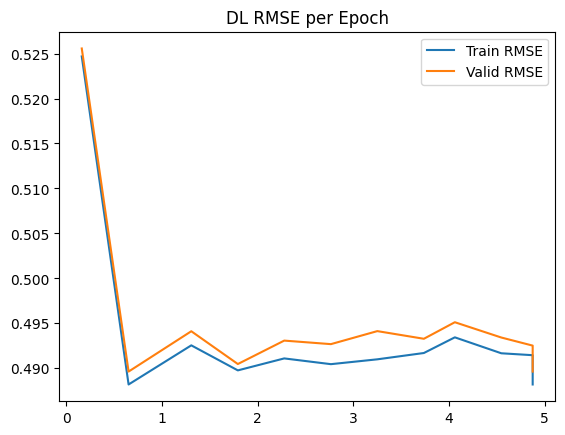

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
              precision    recall  f1-score   support

           0       0.71      0.05      0.09     26425
           1       0.51      0.98      0.67     26501

    accuracy                           0.51     52926
   macro avg       0.61      0.51      0.38     52926
weighted avg       0.61      0.51      0.38     52926



/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


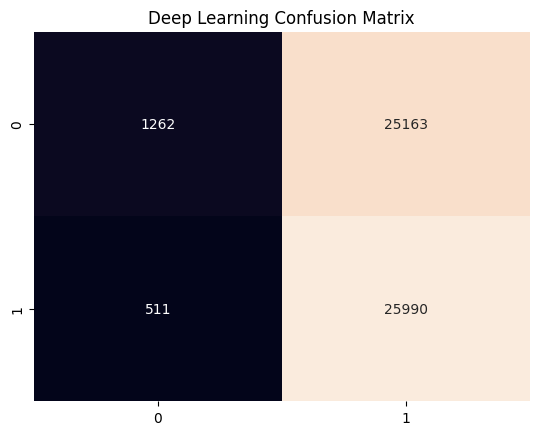

In [26]:
# Scoring history plot
hist = dl.score_history() # Remove .as_data_frame() as it's already a Pandas DataFrame
plt.plot(hist['epochs'], hist['training_rmse'], label='Train RMSE')
plt.plot(hist['epochs'], hist['validation_rmse'], label='Valid RMSE')
plt.legend(); plt.title('DL RMSE per Epoch'); plt.show()
# Confusion & report
pred = dl.predict(test_hf).as_data_frame() # Change hf_test to test_hf
y_pred = pred['predict'].astype(int)
print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.title('Deep Learning Confusion Matrix')
plt.show()